<a href="https://colab.research.google.com/github/gafaronline/Cyberbullying-Detection/blob/develop/CyberBullying_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment Analysis of  Tweets For Detecting CyberBully

In [1]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 22.2MB/s 


In [2]:
file_list = drive.ListFile({'q': "'1bdBtOnxi7-F9caiS4e5wS2VARwJIY1gA' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: sentiment140.zip, id: 1iA9bM2Htuyup0Rarky1WkgKxgWxWaaXI
title: kaggle_implementation_sentiment_analysis.ipynb, id: 1ndn4gNyWNBKqaJXK3wr9H8B1DZipLTDc


In [0]:
tweet_file = 'sentiment140.zip'
content_file = drive.CreateFile({'id': '1iA9bM2Htuyup0Rarky1WkgKxgWxWaaXI'})
content_file.GetContentFile(tweet_file)

In [4]:
ls

adc.json  sample_data/  sentiment140.zip


In [0]:
!unzip -qq sentiment140.zip

In [6]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

    100% |████████████████████████████████| 24.2MB 1.6MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.2.4)
    100% |████████████████████████████████| 10.1MB 4.6MB/s 
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.2 which is incompatible.
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: pandas 0.22.0
    Uninstalling pandas-0.22.0:
      Successfully uninstalled pandas-0.22.0


In [7]:
# Import pandas 
import pandas as pd

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score #Compute confusion matrix to evaluate the accuracy of a classification
#By definition a confusion matrix  is such that  is equal to the number of observations known to be in group  but predicted to be in group .
from sklearn.manifold import TSNE #t-distributed Stochastic Neighbor Embedding. t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. 
from sklearn.feature_extraction.text import TfidfVectorizer #Convert a collection of raw documents to a matrix of TF-IDF features

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences #This class takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as stride, length of history, etc., to produce batches for training/validation
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [0]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
#Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space.
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "CONTAINS CYBERBULLY CONTENT"
NEGATIVE = "DOES NOT CONTAIN CYBERBULLY CONTENT"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [0]:
#dataset_filename = os.listdir("../input")[0]
#dataset_path = os.path.join("..","input",dataset_filename)
#print("Open file:", dataset_path)
#df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

df = pd.read_csv('training_dataset.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS) 

In [11]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [12]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NO BULLY**
* **2** -> **NEUTRAL**
* **4** -> **BULLY **

In [0]:
decode_map = {0: "NO BULLY", 2: "NEUTRAL", 4: "BULLY"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [14]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 626 ms, sys: 2.4 ms, total: 629 ms
Wall time: 631 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

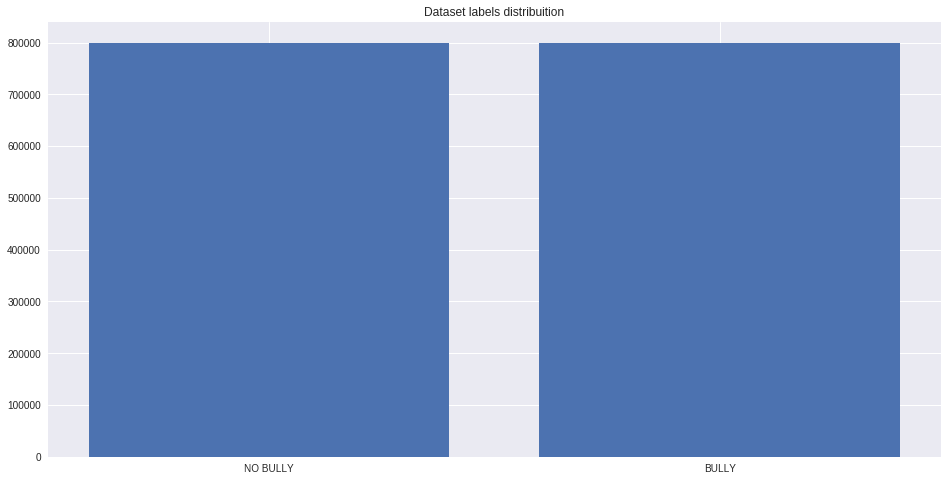

In [15]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [0]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english") #Stemmers remove morphological affixes from words, leaving only the word stem. e.g. -ing, -ly

In [0]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [18]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 48.1 s, sys: 209 ms, total: 48.3 s
Wall time: 48.3 s


### Split train and test

In [19]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [20]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 3.02 s, sys: 310 ms, total: 3.33 s
Wall time: 3.34 s


In [0]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [22]:
w2v_model.build_vocab(documents)

2019-03-01 06:34:57,667 : INFO : collecting all words and their counts
2019-03-01 06:34:57,669 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-03-01 06:34:57,700 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2019-03-01 06:34:57,727 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2019-03-01 06:34:57,754 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2019-03-01 06:34:57,781 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2019-03-01 06:34:57,808 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2019-03-01 06:34:57,835 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2019-03-01 06:34:57,862 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2019-03-01 06:34:57,890 : INFO : PROGRESS: at s

In [23]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [24]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2019-03-01 06:35:02,171 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2019-03-01 06:35:03,245 : INFO : EPOCH 1 - PROGRESS: at 4.67% examples, 365649 words/s, in_qsize 15, out_qsize 0
2019-03-01 06:35:04,434 : INFO : EPOCH 1 - PROGRESS: at 9.99% examples, 372955 words/s, in_qsize 14, out_qsize 7
2019-03-01 06:35:05,414 : INFO : EPOCH 1 - PROGRESS: at 15.41% examples, 393234 words/s, in_qsize 15, out_qsize 0
2019-03-01 06:35:06,431 : INFO : EPOCH 1 - PROGRESS: at 20.48% examples, 397732 words/s, in_qsize 14, out_qsize 1
2019-03-01 06:35:07,450 : INFO : EPOCH 1 - PROGRESS: at 25.48% examples, 398576 words/s, in_qsize 15, out_qsize 0
2019-03-01 06:35:08,458 : INFO : EPOCH 1 - PROGRESS: at 30.56% examples, 401295 words/s, in_qsize 15, out_qsize 0
2019-03-01 06:35:09,478 : INFO : EPOCH 1 - PROGRESS: at 35.75% examples, 403806 words/s, in_qsize 15, out_qsize 0
2019-03-01 06:35:10,498 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 18min 59s, sys: 4.36 s, total: 19min 3s
Wall time: 9min 43s


(263119122, 295270528)

In [25]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-03-01 06:44:45,419 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5733588337898254),
 ('loves', 0.5550423264503479),
 ('loved', 0.5273992419242859),
 ('adore', 0.5078948736190796),
 ('amazing', 0.5019210577011108),
 ('looove', 0.48774227499961853),
 ('awesome', 0.46677109599113464),
 ('lovee', 0.4506368637084961),
 ('loveee', 0.45012974739074707),
 ('loooove', 0.4424011707305908)]

In [26]:
w2v_model.most_similar("ugly")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('boop', 0.3697305917739868),
 ('retarded', 0.32195383310317993),
 ('wrinkles', 0.31859880685806274),
 ('prettier', 0.3155776560306549),
 ('cute', 0.3131271004676819),
 ('dumb', 0.313055157661438),
 ('hideous', 0.30020958185195923),
 ('thick', 0.2979068160057068),
 ('gross', 0.28929734230041504),
 ('photoshopped', 0.2868231236934662)]

In [27]:
w2v_model.most_similar("bully")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('hahahah', 0.2883516550064087),
 ('anorexic', 0.2878303527832031),
 ('naughty', 0.27793291211128235),
 ('cheating', 0.26838815212249756),
 ('jk', 0.2681570053100586),
 ('loner', 0.26737284660339355),
 ('wimp', 0.262611985206604),
 ('fooled', 0.26189249753952026),
 ('chunky', 0.2608267664909363),
 ('nerds', 0.2598419189453125)]

### Tokenize Text

In [28]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 21 s, sys: 113 ms, total: 21.1 s
Wall time: 21 s


In [29]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 30.9 s, sys: 906 ms, total: 31.8 s
Wall time: 31.9 s


### Label Encoder 

In [30]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['BULLY', 'NO BULLY', 'NEUTRAL']

In [31]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [32]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [33]:
y_train[:10]

array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

### Embedding layer

In [34]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [0]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [36]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


2019-03-01 06:45:40,006 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-03-01 06:45:42,542 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [0]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [39]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.


2019-03-01 06:45:43,097 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 1023s 888us/step - loss: 0.5061 - acc: 0.7489 - val_loss: 0.4696 - val_acc: 0.7779
Epoch 2/8
1152000/1152000 [==============================] - 1026s 891us/step - loss: 0.4806 - acc: 0.7662 - val_loss: 0.4582 - val_acc: 0.7832
Epoch 3/8
1152000/1152000 [==============================] - 1031s 895us/step - loss: 0.4741 - acc: 0.7703 - val_loss: 0.4564 - val_acc: 0.7857
Epoch 4/8
1152000/1152000 [==============================] - 1042s 905us/step - loss: 0.4696 - acc: 0.7735 - val_loss: 0.4526 - val_acc: 0.7871
Epoch 5/8
1152000/1152000 [==============================] - 1037s 901us/step - loss: 0.4670 - acc: 0.7752 - val_loss: 0.4507 - val_acc: 0.7880
Epoch 6/8
1152000/1152000 [==============================] - 1025s 890us/step - loss: 0.4650 - acc: 0.7765 - val_loss: 0.4498 - val_acc: 0.7887
Epoch 7/8
1152000/1152000 [==============================] - 1028s 892us/step - los

### Evaluate

In [40]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 112s 350us/step

ACCURACY: 0.7908
LOSS: 0.4457127115249634
CPU times: user 2min 2s, sys: 11.2 s, total: 2min 13s
Wall time: 1min 51s


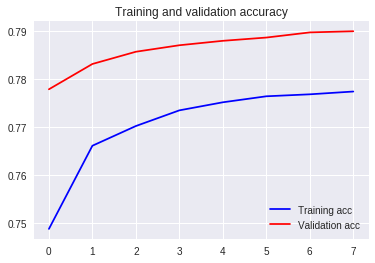

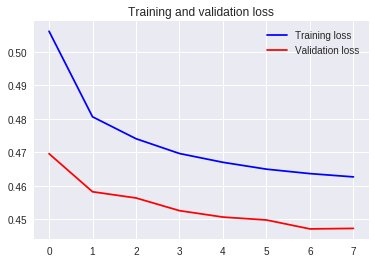

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [0]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [0]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [44]:
predict("You are ugly")

{'elapsed_time': 0.3729839324951172,
 'label': 'CONTAINS CYBERBULLY CONTENT',
 'score': 0.9157074093818665}

In [45]:
predict("you're such a big fat bull, you should be ashamed of yourself")

{'elapsed_time': 0.23888421058654785,
 'label': 'CONTAINS CYBERBULLY CONTENT',
 'score': 0.7865862250328064}

In [46]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.22167682647705078,
 'label': 'CONTAINS CYBERBULLY CONTENT',
 'score': 0.7037743926048279}

In [55]:
predict("life is beautiful")

{'elapsed_time': 0.2308495044708252,
 'label': 'DOES NOT CONTAIN CYBERBULLY CONTENT',
 'score': 0.039321620017290115}

In [73]:
predict("I'll expose your nude")

{'elapsed_time': 0.1922752857208252,
 'label': 'DOES NOT CONTAIN CYBERBULLY CONTENT',
 'score': 0.2565438449382782}

In [47]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=5000) #I reduce the batch size to 5000 from 8000
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

320000/320000 [==============================] - 70s 220us/step
CPU times: user 32.5 s, sys: 5.55 s, total: 38 s
Wall time: 1min 10s


### Confusion Matrix

In [0]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


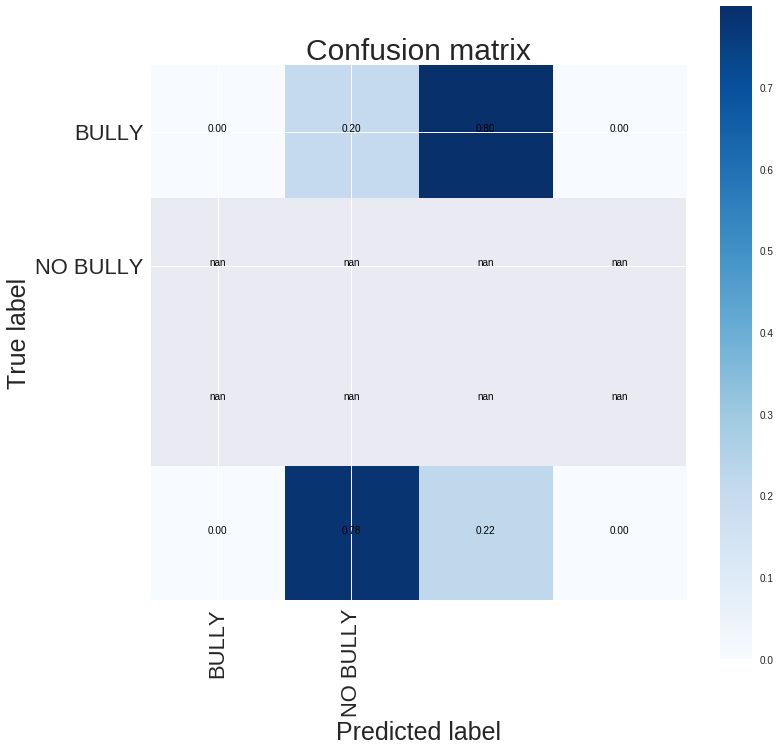

CPU times: user 2.16 s, sys: 320 ms, total: 2.48 s
Wall time: 2.18 s


In [49]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [50]:
print(classification_report(y_test_1d, y_pred_1d))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                                     precision    recall  f1-score   support

                              BULLY       0.00      0.00      0.00    160506
        CONTAINS CYBERBULLY CONTENT       0.00      0.00      0.00         0
DOES NOT CONTAIN CYBERBULLY CONTENT       0.00      0.00      0.00         0
                           NO BULLY       0.00      0.00      0.00    159494

                          micro avg       0.00      0.00      0.00    320000
                          macro avg       0.00      0.00      0.00    320000
                       weighted avg       0.00      0.00      0.00    320000



### Accuracy Score

In [51]:
accuracy_score(y_test_1d, y_pred_1d)

0.0

### Save model

In [52]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2019-03-01 09:06:20,821 : INFO : saving Word2Vec object under model.w2v, separately None
2019-03-01 09:06:20,836 : INFO : not storing attribute vectors_norm
2019-03-01 09:06:20,846 : INFO : not storing attribute cum_table
2019-03-01 09:06:21,752 : INFO : saved model.w2v
